Assignment:4
1. you have to create one supervisor node.
2. create one router function
3. create three more node
3.1 llm call (llm node)
3.2 RAG (rag node)
3.3 web crawler(fetch the info in realtime from internet)
4. created one more node after this for validation for generated output --> explore the validation part how to do that
5. if validation going to be failed in that case again go to supervioser node and then supervisor node will again decide what needs to be call next
6. once the validation will pass then only generate the final output

Supervisor ➝ Router ➝ (LLM / RAG / Web) ➝ ✅ Pydantic Validation ➝ Post-Validation Router ➝ (Final Output / Supervisor Retry)


#### Step 1. Import Libraries

In [ ]:
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, END

#### Step 2. Load env

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

#### Step 4. Init o1-mini Model

In [4]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="o1-mini")
result = model.invoke("Hi")
print(result)

content='Hello! How can I assist you today?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 212, 'prompt_tokens': 9, 'total_tokens': 221, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o1-mini-2024-09-12', 'system_fingerprint': 'fp_3da8b0b088', 'id': 'chatcmpl-BheuX9O4uOod5109Spes342bAIHPt', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--d4b859b8-1ef0-4a01-b545-d5f2940d4316-0' usage_metadata={'input_tokens': 9, 'output_tokens': 212, 'total_tokens': 221, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 192}}


#### Step 5. Embeddings

In [631]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
len(embeddings.embed_query("Elo, mate"))

384

In [6]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [7]:
loader = TextLoader(r"C:\Users\aditi_zg48xl\Downloads\Agentic AI\Assignment_4\Data\genetic_diseases.txt")
docs = loader.load()

In [8]:
docs 

[Document(metadata={'source': 'C:\\Users\\aditi_zg48xl\\Downloads\\Agentic AI\\Assignment_4\\Data\\genetic_diseases.txt'}, page_content="Genetic diseases are medical conditions caused by anomalies in the genome, either inherited from one's parents or acquired through spontaneous mutations. These diseases can be categorized based on the type and location of the genetic defect: single-gene disorders, multifactorial disorders, chromosomal abnormalities, and mitochondrial genetic diseases.\n\nSingle-gene disorders, or monogenic diseases, result from mutations in a single gene. These include well-known conditions such as cystic fibrosis (CF), sickle cell anemia, Tay-Sachs disease, and Huntingtonâ€™s disease. In CF, mutations in the CFTR gene cause defective chloride ion transport, leading to thickened mucus in the lungs and digestive system. Sickle cell anemia, on the other hand, arises from a point mutation in the HBB gene, causing abnormal hemoglobin structure and leading to hemolytic ane

In [9]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 200,
    chunk_overlap = 50
)

In [10]:
new_docs = text_splitter.split_documents(documents = docs)
new_docs

[Document(metadata={'source': 'C:\\Users\\aditi_zg48xl\\Downloads\\Agentic AI\\Assignment_4\\Data\\genetic_diseases.txt'}, page_content="Genetic diseases are medical conditions caused by anomalies in the genome, either inherited from one's parents or acquired through spontaneous mutations. These diseases can be categorized based on the"),
 Document(metadata={'source': 'C:\\Users\\aditi_zg48xl\\Downloads\\Agentic AI\\Assignment_4\\Data\\genetic_diseases.txt'}, page_content='These diseases can be categorized based on the type and location of the genetic defect: single-gene disorders, multifactorial disorders, chromosomal abnormalities, and mitochondrial genetic diseases.'),
 Document(metadata={'source': 'C:\\Users\\aditi_zg48xl\\Downloads\\Agentic AI\\Assignment_4\\Data\\genetic_diseases.txt'}, page_content='Single-gene disorders, or monogenic diseases, result from mutations in a single gene. These include well-known conditions such as cystic fibrosis (CF), sickle cell anemia, Tay-Sachs 

#### Step 6: Create Vector Database

In [11]:
vector_db = FAISS.from_documents(new_docs, embeddings)

In [12]:
retriever = vector_db.as_retriever(search_kwargs={"k" : 5})

In [13]:
retriever.invoke("What are simple-gene disorders")

[Document(id='b75e7148-5eec-408d-99ac-c43d014c7ec2', metadata={'source': 'C:\\Users\\aditi_zg48xl\\Downloads\\Agentic AI\\Assignment_4\\Data\\genetic_diseases.txt'}, page_content='Single-gene disorders, or monogenic diseases, result from mutations in a single gene. These include well-known conditions such as cystic fibrosis (CF), sickle cell anemia, Tay-Sachs disease, and'),
 Document(id='cd81d90e-1b60-40df-8fdc-6084287dd584', metadata={'source': 'C:\\Users\\aditi_zg48xl\\Downloads\\Agentic AI\\Assignment_4\\Data\\genetic_diseases.txt'}, page_content='challenge in predicting and managing these disorders.'),
 Document(id='0a80d25b-428f-4155-9d70-14ed0624d33a', metadata={'source': 'C:\\Users\\aditi_zg48xl\\Downloads\\Agentic AI\\Assignment_4\\Data\\genetic_diseases.txt'}, page_content="Genetic diseases are medical conditions caused by anomalies in the genome, either inherited from one's parents or acquired through spontaneous mutations. These diseases can be categorized based on the"),
 

In [661]:
from pydantic import BaseModel, Field

class RoutingOutput(BaseModel):
    Topic: str = Field(description="Must be one of 'RAG Call', 'LLM Call', or 'Web Crawler'")

In [662]:
from langchain.output_parsers import PydanticOutputParser

In [663]:
parser = PydanticOutputParser(pydantic_object=RoutingOutput)

In [664]:
parser.get_format_instructions

<bound method PydanticOutputParser.get_format_instructions of PydanticOutputParser(pydantic_object=<class '__main__.RoutingOutput'>)>

#### Step 7 Define AgentState

In [665]:
class AgentState(TypedDict):
    message: Annotated[Sequence[BaseModel],operator.add]

In [666]:
AgentState = {}

In [667]:
AgentState["messages"]=[]
AgentState

{'messages': []}

In [668]:
AgentState["messages"].append("Hi, how are you?")

In [669]:
AgentState["messages"].append("Supp")

In [670]:
AgentState["messages"].append("Reply to me")

In [671]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

#### Step 8 Pydantic

In [672]:
class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description='Reasoning behind topic selection')


In [673]:
parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "selected topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

#### Step 9 Define Supervisor that tells which call is required

In [674]:
def function_1(state: AgentState):
    question = state["messages"][-1]
    print("Question:", question)

    template = """
    Your job is to identify and classify the user question into one of the following categories:
    1. RAG Call — if the question is related to genetic diseases.
    2. Web Crawler — if the question is about something that requires current or real-time information (news, today)
    3. LLM Call — if the question is general, like programming questions

    Respond with only one of the following labels: "RAG Call", "Web Crawler", or "LLM Call".

    User query: {question}
    {format_instructions}
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    chain = prompt | model | parser
    response = chain.invoke({"question": question})

    print("Parsed response:", response)
    
    return {"messages": [response.Topic]}

    # raw_label = response.Topic.strip()
    # print("Raw route:", raw_label)

    # label_map = {
    #     "LLM": "LLM Call",
    #     "WEB CRAWLER": "Web Crawler",
    #     "RAG": "RAG Call"
    # }

    # route = label_map.get(raw_label.upper(), raw_label)
    # print("Final route:", route)

    # # ✅ MERGE with incoming state
    # return {**state, "route": route}


#### Step 10 Define router to route to that code

In [675]:
def router(state:AgentState):
    print("-> ROUTER ->")
    
    last_message=state["messages"][-1]
    print("last_message:", last_message)
    
    if "genetic diseases" in last_message.lower():
        return "RAG Call"
    
    elif any(keyword in last_message.lower() for keyword in ["web_crawl", "today", "news"]):
        return "Web Crawler"
    
    else:       
        return "LLM Call"

In [676]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

#### Step 11 RAG Call

In [677]:
# RAG Function
def function_2(state:AgentState):
    print("-> RAG Call ->")
    
    question = state["messages"][0]
    
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"messages": [result]}

#### Step 12 LLM Call

In [ ]:
def function_3(state:AgentState):
    print("->->LLM Call->->")

    question = state["messages"][0]

    # Normal LLM call
    complete_query = "Answer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = model.invoke(complete_query)
    return {"messages": [response.content]}

#### Step 13 Duck Duck Go Search Web Crawling

In [679]:
from langchain_community.tools import DuckDuckGoSearchRun

In [680]:
search = DuckDuckGoSearchRun()

In [681]:

def function_4(state: AgentState):
    print("-> Web Crawler ->")
    question = state["messages"][0]

    answer = search.run(question)

    return {"messages": [answer]}

#### Step 14 Validation

In [682]:
def function_5(state: AgentState):
    print("-> VALIDATION ->")
    last_response = state["messages"][-1]

    if "don't know" in last_response.lower() or "error" in last_response.lower():
        validated = False
    else:
        validated = True

    print("Validation result:", validated)
    state["validated"] = validated
    return state

In [695]:
workflow=StateGraph(AgentState)

#### Step 15 Add Nodes

In [696]:
workflow.add_node("Supervisor",function_1)
workflow.add_node("RAG Call",function_2)
workflow.add_node("LLM Call",function_3)
workflow.add_node("Web Crawler",function_4)
workflow.add_node("Validate", function_5)

In [697]:
workflow.set_entry_point("Supervisor")

#### Step 16 Add Edges

In [698]:
workflow.add_edge("RAG Call", "Validate")
workflow.add_edge("LLM Call", "Validate")
workflow.add_edge("Web Crawler", "Validate")

In [699]:
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG Call": "RAG Call",
        "LLM Call": "LLM Call",
        "Web Crawler": "Web Crawler"
    }
)

workflow.add_conditional_edges(
    "Validate",
    lambda state: "Supervisor" if not state["validated"] else END
)

In [700]:
app=workflow.compile()

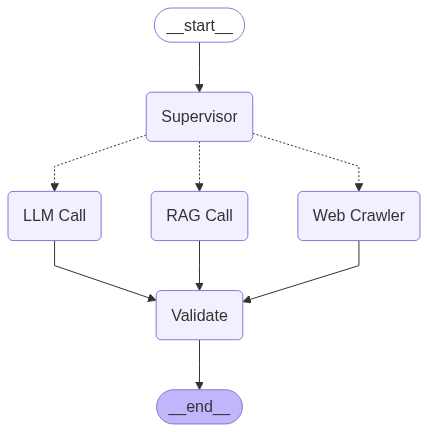

In [701]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [713]:
state1={"messages":["Tell me about Vietnam",], 
        "validated": False
        }

In [716]:
result = app.invoke(state1)
result["messages"][-1]

Question: Tell me about Vietnam
Parsed response: Topic='LLM Call' Reasoning='The user is requesting general information about Vietnam, which is a general knowledge question suitable for an LLM. It does not pertain to genetic diseases or require real-time information.'
-> ROUTER ->
last_message: LLM Call
->->LLM Call->->
-> VALIDATION ->
Validation result: True


'Vietnam is a vibrant Southeast Asian country known for its rich history, diverse culture, stunning landscapes, and dynamic economic growth. Here\'s an overview of various aspects of Vietnam:\n\n### **Geography**\n- **Location:** Vietnam is located on the eastern edge of the Indochinese Peninsula in Southeast Asia. It shares borders with China to the north, Laos and Cambodia to the west, and the South China Sea (also known as the East Sea) to the east and south.\n- **Size:** The country spans approximately 331,212 square kilometers (127,880 square miles), making it slightly larger than Germany.\n- **Topography:** Vietnam features diverse landscapes, including the mountainous regions of the north (such as the Hoàng Liên Son range and Fansipan, the highest peak in Indochina), the fertile deltas of the Red River and Mekong River in the north and south respectively, extensive coastlines, and bustling urban centers.\n\n### **History**\n- **Ancient to Colonial Period:** Vietnam has a long hi